In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import sklearn

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

from tensorflow import keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from pandas import read_excel, DataFrame, Series
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from numpy.random import seed
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Загружаем первый датасет (базальтопластик) и посмотрим на названия столбцов
df = pd.read_excel(r"cleaned_data(2).xlsx")
df.shape

(930, 15)

Прогнозируем модуль упругости при растяжении, ГПа

In [5]:
# Применяем нормализацию для данных
normalizer = Normalizer()
normalized_data = normalizer.fit_transform(df)  # Нормализуем все признаки
df_normalized = pd.DataFrame(normalized_data, columns=df.columns)  # Преобразуем в DataFrame с сохранением названий колонок

# Разделение нормализованных данных на признаки и целевую переменную
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(
    df_normalized.drop(columns=['Модуль упругости при растяжении, ГПа']),  # Все признаки без целевой переменной
    df[['Модуль упругости при растяжении, ГПа']],  # Целевая переменная
    test_size=0.3,  # 30% данных используется для тестирования
    random_state=42  # Фиксация random_state для воспроизводимости результатов
)

# Ожидаемая проверка правильности распределения выборок
assert df_normalized.shape[0] == x_train_2.shape[0] + x_test_2.shape[0], \
    "Количество строк в нормализованных данных не совпадает с суммой строк в обучающей и тестовой выборках."

# Печать размеров выборок для проверки
print(f"Размеры обучающей выборки X: {x_train_2.shape}, тестовой выборки X: {x_test_2.shape}")
print(f"Размеры обучающей выборки y: {y_train_2.shape}, тестовой выборки y: { y_test_2.shape}")

Размеры обучающей выборки X: (651, 14), тестовой выборки X: (279, 14)
Размеры обучающей выборки y: (651, 1), тестовой выборки y: (279, 1)


In [6]:
x_train_2.head()

,Unnamed: 0.1,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Прочность при растяжении, МПа","Потребление смолы, г/м2",Угол нашивки,Шаг нашивки,Плотность нашивки
606,0.192376,0.192376,0.001063,0.557559,0.255545,0.045456,0.004896,0.090003,0.100484,0.724704,0.059191,0.000283,0.001279,0.017701
593,0.185910,0.185910,0.000789,0.548058,0.115376,0.030430,0.006919,0.106706,0.138944,0.761715,0.068392,0.000280,0.001724,0.014208
485,0.158888,0.158888,0.000851,0.577976,0.221505,0.022577,0.005757,0.065677,0.210910,0.717911,0.032935,0.000288,0.001841,0.012637
494,0.163776,0.163776,0.000696,0.536208,0.168332,0.027507,0.006475,0.075210,0.073340,0.781603,0.083239,0.000292,0.001416,0.021212
752,0.257309,0.257309,0.000757,0.611673,0.192550,0.040341,0.007384,0.076104,0.085306,0.662788,0.039125,0.000308,0.003607,0.016562


In [7]:
y_train_2

,"Модуль упругости при растяжении, ГПа"
606,79.290587
593,74.910738
485,69.764838
494,66.824427
752,73.137189
...,...
106,74.519119
270,76.439166
860,71.237408
435,77.141941


In [8]:
y_train_2.shape

(651, 1)

In [9]:
# Функция для предсказания с моделью, которая всегда возвращает среднее значение целевой переменной
def mean_model(y_test):
    """
    Эта функция возвращает предсказания модели, которая всегда прогнозирует среднее значение
    целевой переменной для всех элементов в тестовой выборке.

    Parameters:
    y_test (pandas.Series or numpy.ndarray): Целевая переменная для тестовой выборки.

    Returns:
    list: Список предсказанных значений, где каждый элемент равен среднему значению целевой переменной.
    """
    mean_value = np.mean(y_test)  # Вычисляем среднее значение целевой переменной
    return [mean_value for _ in range(len(y_test))]  # Возвращаем список из одинаковых значений

# Применение функции для получения предсказаний
y_2_pred_mean = mean_model(y_test_2)

# Печать первых нескольких предсказаний для проверки
print(f"Пример предсказанных значений с моделью среднего: {y_2_pred_mean[:5]}")

Пример предсказанных значений с моделью среднего: [73.24472670034491, 73.24472670034491, 73.24472670034491, 73.24472670034491, 73.24472670034491]


Проверка различных моделей при стандартных параметрах

Метод опорных векторов - 1 

In [10]:
# Создание модели с использованием SVR с нормализацией данных
svr2 = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=500.0, epsilon=1.0))

# Обучаем модель на тренировочных данных
svr2.fit(x_train_2, np.ravel(y_train_2))

# Прогнозируем значения на тестовой выборке
y_pred_svr2 = svr2.predict(x_test_2)

# Оценка модели с помощью различных метрик
mae_svr2 = mean_absolute_error(y_test_2, y_pred_svr2)  # Средняя абсолютная ошибка
mse_svr_elast2 = mean_squared_error(y_test_2, y_pred_svr2)  # Среднеквадратическая ошибка

# Вывод результатов для тренировочной выборки
print('Support Vector Regression Results Train:') 
print(f"Test score (Train set): {svr2.score(x_train_2, y_train_2):.2f}")  # Скор для тренировочной выборки

# Вывод метрик для тестовой выборки
print('Support Vector Regression Results:')
print(f'SVR_MAE: {round(mae_svr2, 2)}')  # Средняя абсолютная ошибка
print(f'SVR_MAPE: {round(mean_absolute_percentage_error(y_test_2, y_pred_svr2), 2):.2f}')  # Средняя абсолютная процентная ошибка
print(f'SVR_MSE: {round(mse_svr_elast2, 2)}')  # Среднеквадратическая ошибка
print(f"SVR_RMSE: {round(np.sqrt(mse_svr_elast2), 2)}")  # Корень из среднеквадратической ошибки

# Оценка точности модели на тестовой выборке
print(f"Test score (Test set): {svr2.score(x_test_2, y_test_2):.2f}")  # Скор для тестовой выборки

Support Vector Regression Results Train:
Test score (Train set): 0.90
Support Vector Regression Results:
SVR_MAE: 3.25
SVR_MAPE: 0.04
SVR_MSE: 16.97
SVR_RMSE: 4.12
Test score (Test set): -0.88


In [11]:
# Оценка модели, которая всегда предсказывает среднее значение целевой переменной

# Вычисляем метрики для модели, которая всегда предсказывает среднее значение
mse_lin_elast2_mean = mean_squared_error(y_test_2, y_2_pred_mean)  # Среднеквадратическая ошибка
mae_lin_elast2_mean = mean_absolute_error(y_test_2, y_2_pred_mean)  # Средняя абсолютная ошибка
rmse_lin_elast2_mean = np.sqrt(mse_lin_elast2_mean)  # Корень из среднеквадратической ошибки

# Выводим результаты
print("Результаты для модели, предсказывающей среднее целевое значение:")
print(f"MAE for mean target: {mae_lin_elast2_mean:.2f}")  # Средняя абсолютная ошибка
print(f"MSE for mean target: {mse_lin_elast2_mean:.2f}")  # Среднеквадратическая ошибка
print(f"RMSE for mean target: {rmse_lin_elast2_mean:.2f}")  # Корень из среднеквадратической ошибки

Результаты для модели, предсказывающей среднее целевое значение:
MAE for mean target: 2.44
MSE for mean target: 9.03
RMSE for mean target: 3.00


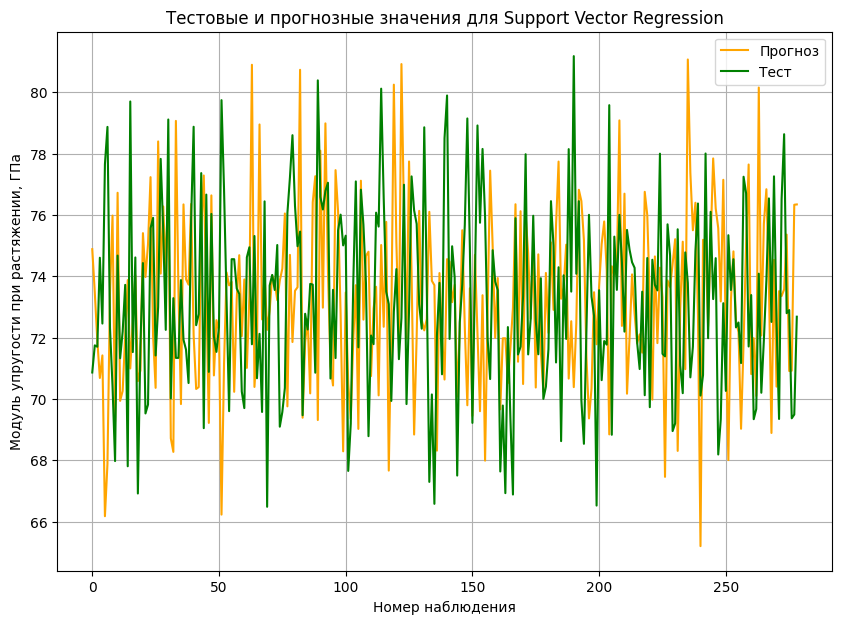

In [12]:
# Настройка графика
plt.figure(figsize=(10, 7))

# Заголовок графика
plt.title("Тестовые и прогнозные значения для Support Vector Regression")

# Построение графиков
plt.plot(y_pred_svr2, label="Прогноз", color="orange")
plt.plot(y_test_2.values, label="Тест", color="green")

# Настройка подписей осей
plt.xlabel("Номер наблюдения")
plt.ylabel("Модуль упругости при растяжении, ГПа")

# Добавление легенды
plt.legend()

# Добавление сетки
plt.grid(True)

# Отображение графика
plt.show()

Метод случайного леса - Random Forest Regressor - 2

In [13]:
# Инициализация модели случайного леса с гиперпараметрами
rfr2 = RandomForestRegressor(n_estimators=15, max_depth=7, random_state=33)

# Обучение модели на тренировочных данных
rfr2.fit(x_train_2, y_train_2.values)

# Прогнозирование на тестовой выборке
y2_pred_forest = rfr2.predict(x_test_2)

# Оценка качества модели с помощью метрик
mae_rfr2 = mean_absolute_error(y_test_2, y2_pred_forest)
mse_rfr_elast2 = mean_squared_error(y_test_2, y2_pred_forest)

# Выводим результаты для тренировочной выборки
print('Random Forest Regressor Results Train:')
print(f"Test score (Train set): {rfr2.score(x_train_2, y_train_2):.2f}")  # Скор для тренировочной выборки

# Выводим метрики для тестовой выборки
print('Random Forest Regressor Results:')
print(f'RF_MAE: {round(mae_rfr2, 2)}')  # Средняя абсолютная ошибка
print(f'RF_MAPE: {round(mean_absolute_percentage_error(y_test_2, y2_pred_forest), 2)}')  # Средняя абсолютная процентная ошибка
print(f'RF_MSE: {round(mse_rfr_elast2, 2)}')  # Среднеквадратическая ошибка
print(f"RF_RMSE: {round(np.sqrt(mse_rfr_elast2), 2)}")  # Корень из среднеквадратической ошибки

# Оценка точности модели на тестовой выборке
print(f"Test score (Test set): {rfr2.score(x_test_2, y_test_2):.2f}")  # Скор для тестовой выборки

Random Forest Regressor Results Train:
Test score (Train set): 0.46
Random Forest Regressor Results:
RF_MAE: 2.52
RF_MAPE: 0.03
RF_MSE: 9.45
RF_RMSE: 3.07
Test score (Test set): -0.05


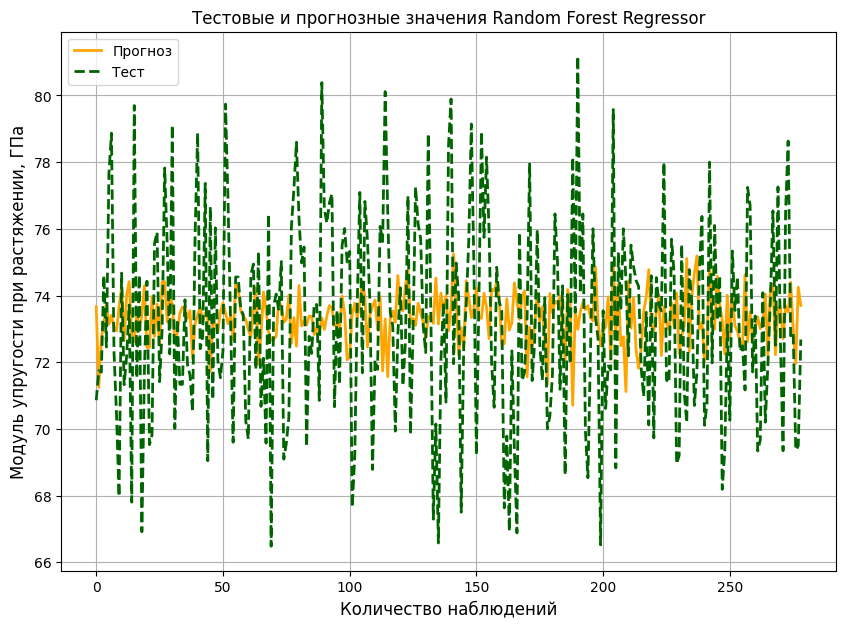

In [14]:
# Создаем график
plt.figure(figsize=(10, 7))

# Заголовок графика
plt.title("Тестовые и прогнозные значения Random Forest Regressor")

# График для прогнозных значений
plt.plot(y2_pred_forest, label="Прогноз", color="orange", linestyle='-', linewidth=2)

# График для тестовых значений
plt.plot(y_test_2.values, label="Тест", color='darkgreen', linestyle='--', linewidth=2)

# Подписи осей
plt.xlabel("Количество наблюдений", fontsize=12)
plt.ylabel("Модуль упругости при растяжении, ГПа", fontsize=12)

# Добавляем легенду
plt.legend(loc='upper left')

# Добавляем сетку для удобства восприятия
plt.grid(True)

# Показываем график
plt.show()

Метод линейной регрессии - Linear Regression - 3

Linear Regression Results Train:
Test score: 0.02
Linear Regression Results:
lr_MAE:  2.5
lr_MAPE: 0.03
lr_MSE: 9.51
lr_RMSE: 3.08
Test score: -0.05


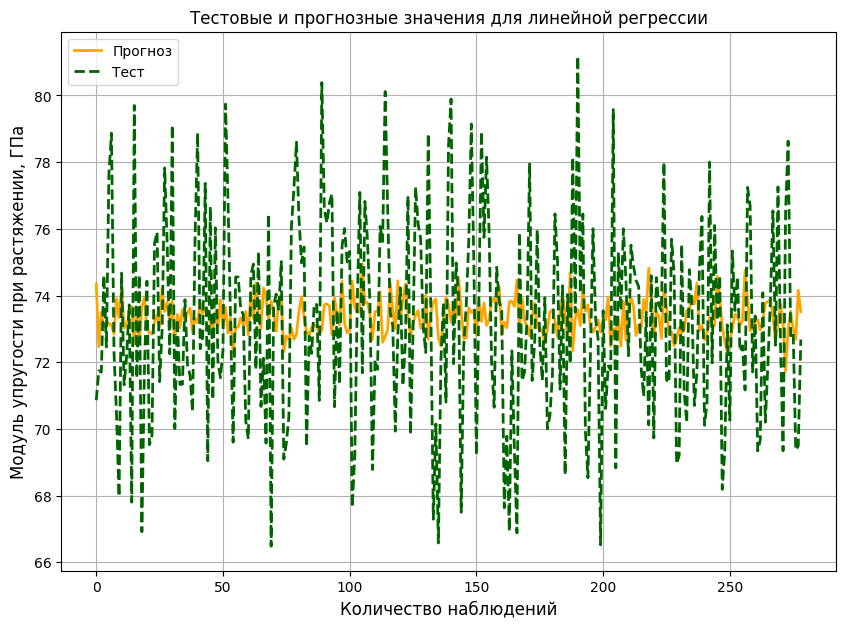

In [15]:
# Создаем модель линейной регрессии
lr2 = LinearRegression()

# Обучаем модель
lr2.fit(x_train_2, y_train_2)

# Делаем предсказания
y_pred_lr2 = lr2.predict(x_test_2)

# Оцениваем точность на тестовой выборке
mae_lr2 = mean_absolute_error(y_pred_lr2, y_test_2)
mse_lin_elast2 = mean_squared_error(y_test_2, y_pred_lr2)

# Выводим результаты
print('Linear Regression Results Train:')  # Скор для тренировочной выборки
print("Test score: {:.2f}".format(lr2.score(x_train_2, y_train_2)))  # R2 на тренировочной выборке
print('Linear Regression Results:')
print('lr_MAE: ', round(mae_lr2, 2))  # Средняя абсолютная ошибка
print('lr_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_2, y_pred_lr2)))  # Средняя абсолютная процентная ошибка
print('lr_MSE: {:.2f}'.format(mse_lin_elast2))  # Среднеквадратическая ошибка
print("lr_RMSE: {:.2f}".format(np.sqrt(mse_lin_elast2)))  # Корень из среднеквадратической ошибки
print("Test score: {:.2f}".format(lr2.score(x_test_2, y_test_2)))  # R2 на тестовой выборке

# Построим график для сравнения предсказанных и тестовых значений
plt.figure(figsize=(10, 7))
plt.title("Тестовые и прогнозные значения для линейной регрессии")

# График для предсказанных значений
plt.plot(y_pred_lr2, label="Прогноз", color="orange", linestyle='-', linewidth=2)

# График для тестовых значений
plt.plot(y_test_2.values, label="Тест", color='darkgreen', linestyle='--', linewidth=2)

# Подписи осей
plt.xlabel("Количество наблюдений", fontsize=12)
plt.ylabel("Модуль упругости при растяжении, ГПа", fontsize=12)

# Легенда
plt.legend(loc='upper left')

# Сетка для удобства восприятия
plt.grid(True)

# Показать график
plt.show()

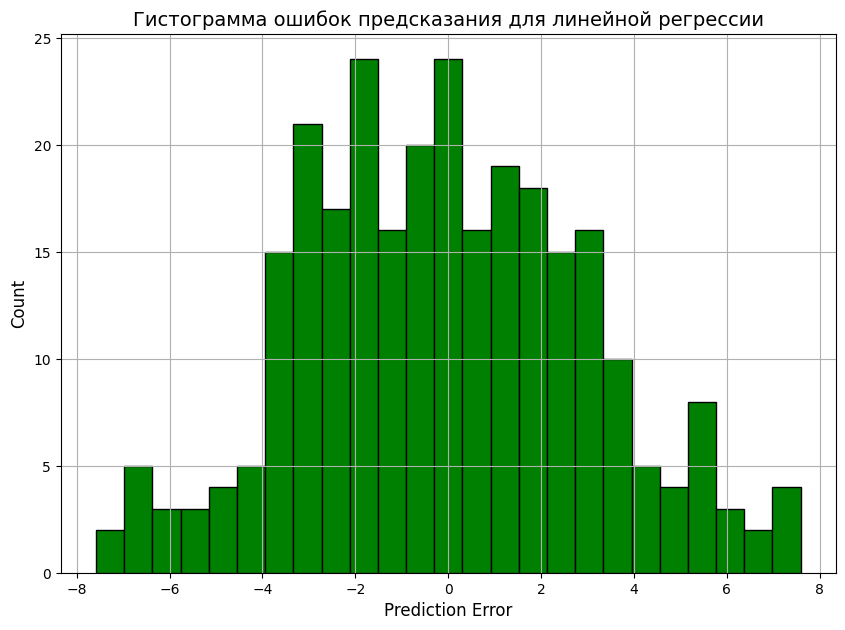

In [16]:
# Рассчитываем ошибку предсказания
error = y_test_2 - y_pred_lr2

# Строим гистограмму ошибок предсказания
plt.figure(figsize=(10, 7))
plt.hist(error, bins=25, color='g', edgecolor='black')

# Добавляем подписи и заголовок
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Гистограмма ошибок предсказания для линейной регрессии', fontsize=14)

# Показываем график
plt.grid(True)
plt.show()

In [17]:
# Обучение модели Gradient Boosting Regressor
gbr2 = make_pipeline(StandardScaler(), GradientBoostingRegressor())
gbr2.fit(x_train_2, np.ravel(y_train_2))

# Прогнозирование на тестовой выборке
y_pred_gbr2 = gbr2.predict(x_test_2)

# Вычисление различных метрик
mae_gbr2 = mean_absolute_error(y_pred_gbr2, y_test_2)
mse_gbr_elast2 = mean_squared_error(y_test_2, y_pred_gbr2)

# Вывод результатов для тренировочной выборки
print('Gradient Boosting Regressor Results Train:')
print("Test score (Train set): {:.2f}".format(gbr2.score(x_train_2, y_train_2)))  # Коэффициент детерминации для тренировочной выборки

# Вывод метрик для тестовой выборки
print('Gradient Boosting Regressor Results:')
print('GBR_MAE: {:.2f}'.format(mae_gbr2))  # Средняя абсолютная ошибка
print('GBR_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_2, y_pred_gbr2)))  # Средняя абсолютная процентная ошибка
print('GBR_MSE: {:.2f}'.format(mse_gbr_elast2))  # Среднеквадратическая ошибка
print("GBR_RMSE: {:.2f}".format(np.sqrt(mse_gbr_elast2)))  # Корень из среднеквадратической ошибки

# Оценка модели на тестовой выборке
print("Test score (Test set): {:.2f}".format(gbr2.score(x_test_2, y_test_2)))  # Коэффициент детерминации для тестовой выборки

Gradient Boosting Regressor Results Train:
Test score (Train set): 0.48
Gradient Boosting Regressor Results:
GBR_MAE: 2.59
GBR_MAPE: 0.04
GBR_MSE: 10.17
GBR_RMSE: 3.19
Test score (Test set): -0.13


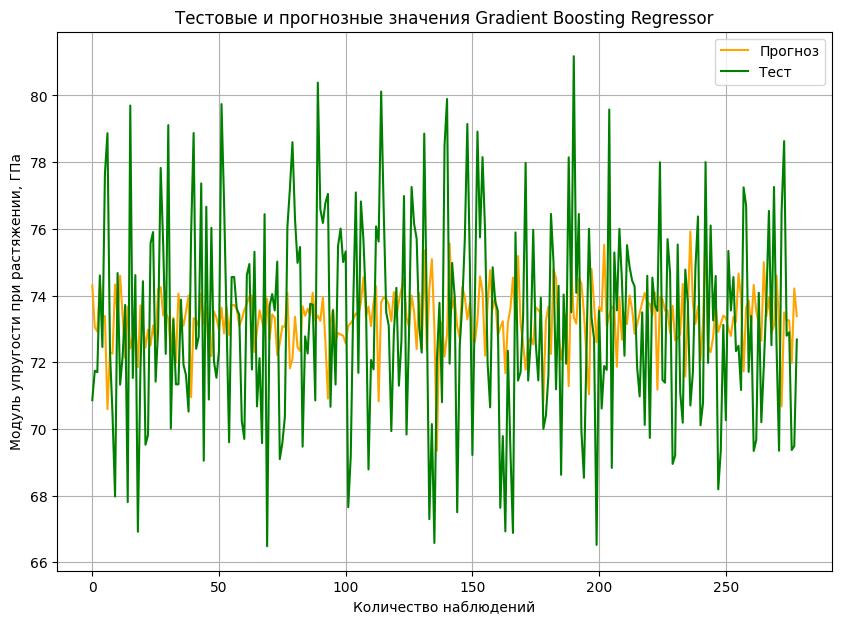

In [18]:
# Построение графика для сравнения тестовых и прогнозных значений
plt.figure(figsize=(10, 7))
plt.title("Тестовые и прогнозные значения Gradient Boosting Regressor")
plt.plot(y_pred_gbr2, label="Прогноз", color="orange")  # Прогнозные значения
plt.plot(y_test_2.values, label="Тест", color="green")  # Тестовые значения
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend(loc='upper right')  # Легенда в верхнем правом углу
plt.grid(True)
plt.show()

In [19]:
# Инициализация модели метода ближайших соседей (K-Nearest Neighbors Regressor)
knn_model = KNeighborsRegressor(n_neighbors=5)

# Обучение модели на тренировочных данных
knn_model.fit(x_train_2, y_train_2)

# Прогнозирование значений для тестовой выборки
y_pred_knn_model = knn_model.predict(x_test_2)

# Оценка качества модели с использованием различных метрик
mae_knn_model = mean_absolute_error(y_pred_knn_model, y_test_2)  # Средняя абсолютная ошибка
mse_knn_model = mean_squared_error(y_test_2, y_pred_knn_model)    # Среднеквадратическая ошибка

# Вывод результатов на тренировочной выборке
print('Результаты модели K-Nearest Neighbors (KNN) на тренировочной выборке:')
print(f"Коэффициент детерминации (R^2) на тренировочной выборке: {knn_model.score(x_train_2, y_train_2):.2f}")

# Вывод метрик для тестовой выборки
print('Результаты модели K-Nearest Neighbors (KNN) на тестовой выборке:')
print(f'Средняя абсолютная ошибка (MAE): {round(mae_knn_model, 2)}')
print(f'Средняя абсолютная процентная ошибка (MAPE): {round(mean_absolute_percentage_error(y_test_2, y_pred_knn_model), 2):.2f}')
print(f'Среднеквадратическая ошибка (MSE): {round(mse_knn_model, 2)}')
print(f'Корень из среднеквадратической ошибки (RMSE): {round(np.sqrt(mse_knn_model), 2)}')

# Вывод коэффициента детерминации для тестовой выборки
print(f"Коэффициент детерминации (R^2) на тестовой выборке: {knn_model.score(x_test_2, y_test_2):.2f}")

Результаты модели K-Nearest Neighbors (KNN) на тренировочной выборке:
Коэффициент детерминации (R^2) на тренировочной выборке: 0.20
Результаты модели K-Nearest Neighbors (KNN) на тестовой выборке:
Средняя абсолютная ошибка (MAE): 2.65
Средняя абсолютная процентная ошибка (MAPE): 0.04
Среднеквадратическая ошибка (MSE): 10.78
Корень из среднеквадратической ошибки (RMSE): 3.28
Коэффициент детерминации (R^2) на тестовой выборке: -0.19


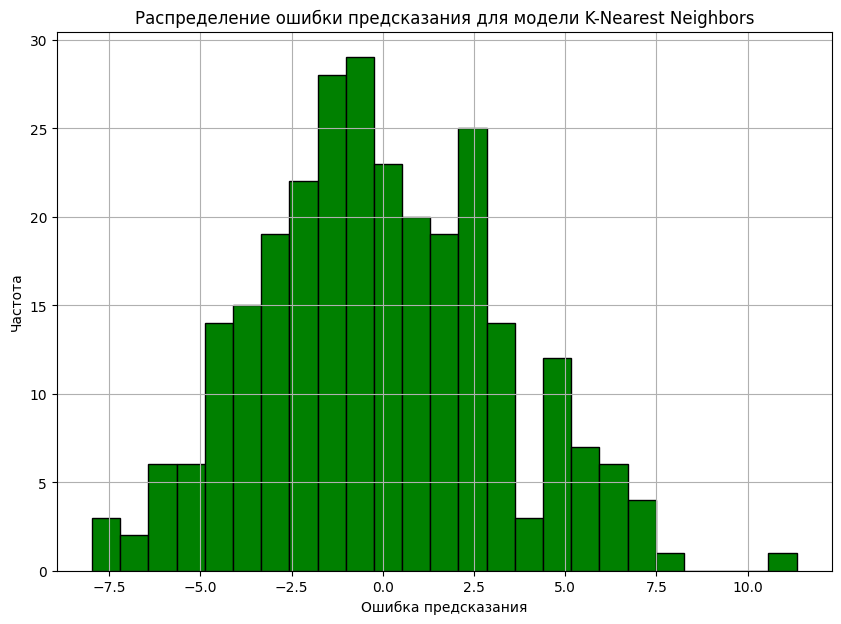

In [20]:
# Вычисление ошибки предсказания для каждой точки
prediction_error = y_test_2 - y_pred_knn_model

# Построение гистограммы распределения ошибки предсказания
plt.figure(figsize=(10, 7))
plt.hist(prediction_error, bins=25, color="g", edgecolor="black")

# Настройка подписей осей и заголовка
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Распределение ошибки предсказания для модели K-Nearest Neighbors')

# Отображение сетки для удобства восприятия
plt.grid(True)

# Показ графика
plt.show()

In [21]:
# Построение модели дерева решений (Decision Tree Regressor)
dtr2 = DecisionTreeRegressor(random_state=42)  # Установлен seed для воспроизводимости
dtr2.fit(x_train_2, y_train_2.values)  # Обучение модели на тренировочных данных

# Получение предсказаний для тестовой выборки
y_pred_dtr2 = dtr2.predict(x_test_2)

# Оценка качества модели с использованием различных метрик
mae_dtr2 = mean_absolute_error(y_pred_dtr2, y_test_2)
mse_dtr_elast2 = mean_squared_error(y_test_2, y_pred_dtr2)
mape_dtr2 = mean_absolute_percentage_error(y_test_2, y_pred_dtr2)
rmse_dtr2 = np.sqrt(mse_dtr_elast2)

# Вывод результатов
print('Результаты модели "Дерево решений" на тренировочной выборке:')
print("Коэффициент детерминации на тренировочной выборке: {:.2f}".format(dtr2.score(x_train_2, y_train_2)))
print('Результаты модели "Дерево решений" на тестовой выборке:')
print('MAE (Средняя абсолютная ошибка): {:.2f}'.format(mae_dtr2))
print('MSE (Среднеквадратичная ошибка): {:.2f}'.format(mse_dtr_elast2))
print("RMSE (Корень из среднеквадратичной ошибки): {:.2f}".format(rmse_dtr2))
print("MAPE (Средняя абсолютная процентная ошибка): {:.2f}".format(mape_dtr2))
print("Коэффициент детерминации на тестовой выборке: {:.2f}".format(dtr2.score(x_test_2, y_test_2)))

Результаты модели "Дерево решений" на тренировочной выборке:
Коэффициент детерминации на тренировочной выборке: 1.00
Результаты модели "Дерево решений" на тестовой выборке:
MAE (Средняя абсолютная ошибка): 3.53
MSE (Среднеквадратичная ошибка): 19.65
RMSE (Корень из среднеквадратичной ошибки): 4.43
MAPE (Средняя абсолютная процентная ошибка): 0.05
Коэффициент детерминации на тестовой выборке: -1.18


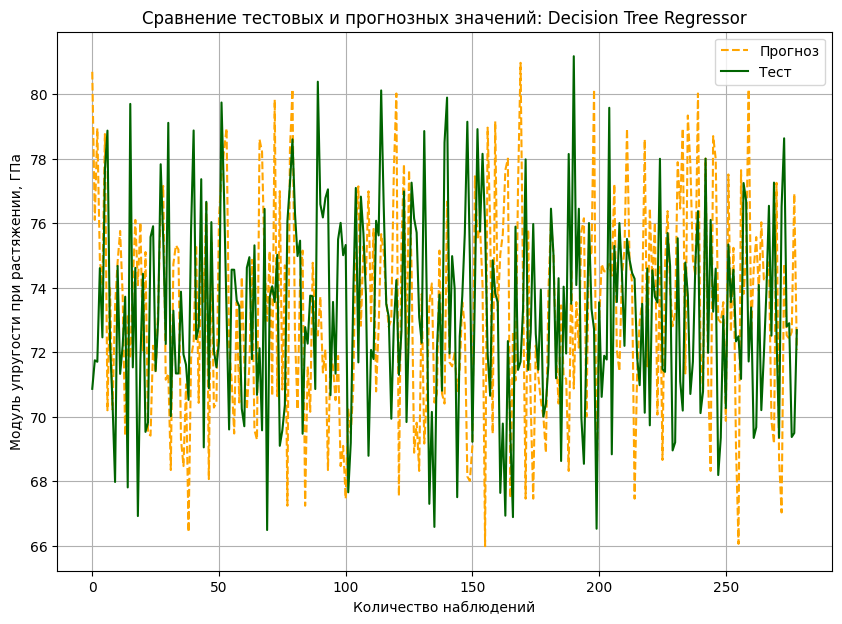

In [22]:
# Построение графика для сравнения тестовых и прогнозных значений
plt.figure(figsize=(10, 7))
plt.title("Сравнение тестовых и прогнозных значений: Decision Tree Regressor")
plt.plot(y_pred_dtr2, label="Прогноз", color='orange', linestyle='--')  # Прогнозируемые значения
plt.plot(y_test_2.values, label="Тест", color='darkgreen', linestyle='-')  # Тестовые значения
plt.xlabel("Количество наблюдений")  # Подпись оси X
plt.ylabel("Модуль упругости при растяжении, ГПа")  # Подпись оси Y
plt.legend()  # Легенда
plt.grid(True)  # Включаем сетку для лучшей читаемости графика
plt.show()  # Отображаем график

In [23]:
# Стохастический градиентный спуск (SGD) - Stochastic Gradient Descent Regressor - 7

# Создаем и обучаем модель SGD Regressor
sdg2 = SGDRegressor()
sdg2.fit(x_train_2, y_train_2)

# Прогнозируем значения на тестовой выборке
y_pred_sdg2 = sdg2.predict(x_test_2)

# Оценка модели
mae_sdg2 = mean_absolute_error(y_pred_sdg2, y_test_2)
mse_sdg_elast2 = mean_squared_error(y_test_2, y_pred_sdg2)

# Вывод результатов на тренировочной выборке
print('Stochastic Gradient Descent Regressor Results Train:')
print("Test score: {:.2f}".format(sdg2.score(x_train_2, y_train_2)))  # Скор для тренировочной выборки

# Вывод итоговых метрик для тестовой выборки
print('Stochastic Gradient Descent Regressor Results:')
print('SGD_MAE: ', round(mae_sdg2))  # Средняя абсолютная ошибка
print('SGD_MSE: {:.2f}'.format(mse_sdg_elast2))  # Среднеквадратичная ошибка
print("SGD_RMSE: {:.2f}".format(np.sqrt(mse_sdg_elast2)))  # Корень из среднеквадратичной ошибки
print('SGD_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_2, y_pred_sdg2)))  # Средняя абсолютная ошибка в процентах
print("Test score: {:.2f}".format(sdg2.score(x_test_2, y_test_2)))  # Скор для тестовой выборки


Stochastic Gradient Descent Regressor Results Train:
Test score: -0.02
Stochastic Gradient Descent Regressor Results:
SGD_MAE:  2
SGD_MSE: 9.33
SGD_RMSE: 3.05
SGD_MAPE: 0.03
Test score: -0.03


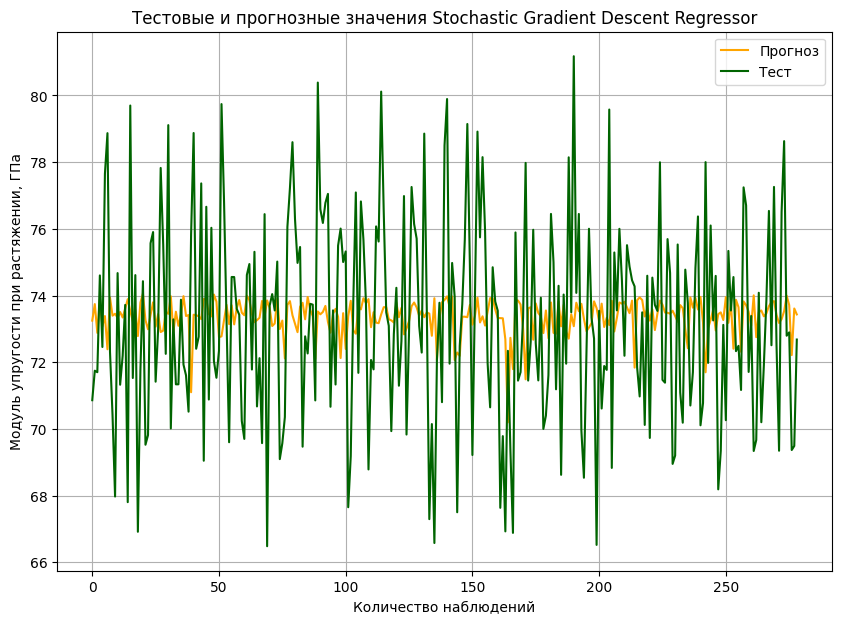

In [24]:
# Визуализация результатов для Stochastic Gradient Descent Regressor
plt.figure(figsize = (10, 7))

# Установка заголовка графика
plt.title("Тестовые и прогнозные значения Stochastic Gradient Descent Regressor")

# Отображение прогнозов на графике (оранжевым цветом)
plt.plot(y_pred_sdg2, label = "Прогноз", color = 'orange')

# Отображение тестовых значений на графике (темно-зеленым цветом)
plt.plot(y_test_2.values, label = "Тест", color = 'darkgreen')

# Метки осей
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")

# Легенда для различения линий
plt.legend()

# Включаем сетку на графике для лучшей видимости
plt.grid(True)

# Показ графика
plt.show()

In [25]:
# Многослойный перцептрон - Multi-layer Perceptron regressor - 8

mlp2 = MLPRegressor(random_state = 1, max_iter = 500)
mlp2.fit(x_train_2, y_train_2)  # Обучаем модель
y_pred_mlp2 = mlp2.predict(x_test_2)  # Прогнозируем на тестовой выборке

# Оценка ошибок модели
mae_mlp2 = mean_absolute_error(y_pred_mlp2, y_test_2)
mse_mlp_elast2 = mean_squared_error(y_test_2, y_pred_mlp2)

# Выводим результаты
print('Multi-layer Perceptron Regressor Results Train:')
print("Test score: {:.2f}".format(mlp2.score(x_train_2, y_train_2)))  # Коэффициент детерминации для тренировочной выборки
print('Multi-layer Perceptron Regressor Results:')
print('MLP_MAE: ', round(mae_mlp2))  # MAE для MLP
print('MLP_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_2, y_pred_mlp2)))  # MAPE для MLP
print('MLP_MSE: {:.2f}'.format(mse_mlp_elast2))  # MSE для MLP
print("MLP_RMSE: {:.2f}".format(np.sqrt(mse_mlp_elast2)))  # RMSE для MLP
print("Test score: {:.2f}".format(mlp2.score(x_test_2, y_test_2)))  # Коэффициент детерминации для тестовой выборки

Multi-layer Perceptron Regressor Results Train:
Test score: -0.73
Multi-layer Perceptron Regressor Results:
MLP_MAE:  3
MLP_MAPE: 0.04
MLP_MSE: 16.37
MLP_RMSE: 4.05
Test score: -0.81


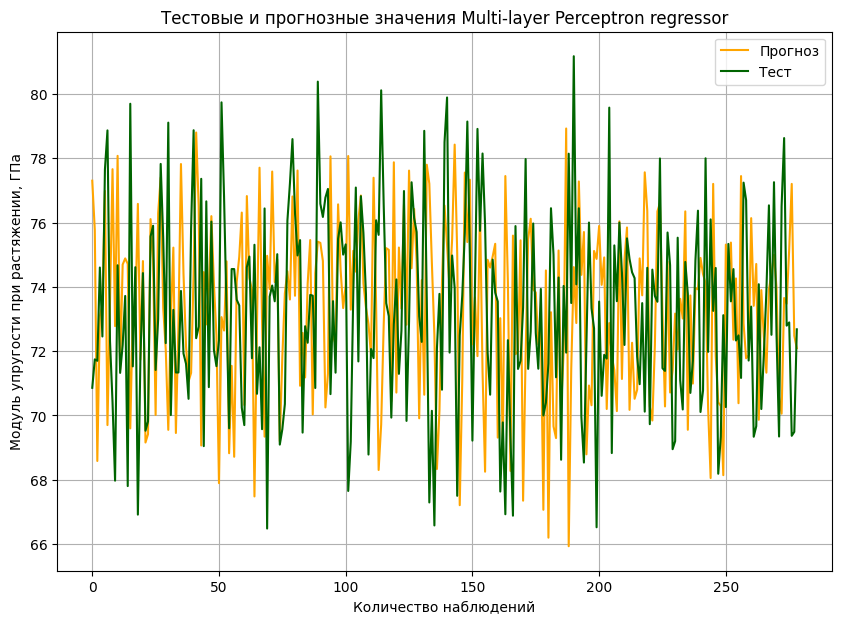

In [26]:
plt.figure(figsize = (10, 7))
plt.title("Тестовые и прогнозные значения Multi-layer Perceptron regressor")
plt.plot(y_pred_mlp2, label = "Прогноз", color = 'orange')
plt.plot(y_test_2.values, label = "Тест", color = 'darkgreen')
plt.xlabel("Количество наблюдений")
plt.ylabel("Модуль упругости при растяжении, ГПа")
plt.legend()
plt.grid(True);

In [27]:
# Лассо регрессия - the Lasso - 9

clf2 = linear_model.Lasso(alpha = 0.1)  # Создаем модель Lasso с заданным параметром alpha
clf2.fit(x_train_2, y_train_2)  # Обучаем модель
y_pred_clf2 = clf2.predict(x_test_2)  # Прогнозируем на тестовой выборке

# Оценка ошибок модели
mae_clf2 = mean_absolute_error(y_pred_clf2, y_test_2)
mse_clf_elast2 = mean_squared_error(y_test_2, y_pred_clf2)

# Выводим результаты
print('Lasso Regressor Results Train:')
print("Train score: {:.2f}".format(clf2.score(x_train_2, y_train_2)))  # Коэффициент детерминации для тренировочной выборки
print('Lasso Regressor Results:')
print('Lasso_MAE: ', round(mae_clf2))  # MAE для Lasso
print('Lasso_MAPE: {:.2f}'.format(mean_absolute_percentage_error(y_test_2, y_pred_clf2)))  # MAPE для Lasso
print('Lasso_MSE: {:.2f}'.format(mse_clf_elast2))  # MSE для Lasso
print("Lasso_RMSE: {:.2f}".format(np.sqrt(mse_clf_elast2)))  # RMSE для Lasso
print("Test score: {:.2f}".format(clf2.score(x_test_2, y_test_2)))  # Коэффициент детерминации для тестовой выборки

Lasso Regressor Results Train:
Train score: 0.00
Lasso Regressor Results:
Lasso_MAE:  2
Lasso_MAPE: 0.03
Lasso_MSE: 9.04
Lasso_RMSE: 3.01
Test score: -0.00


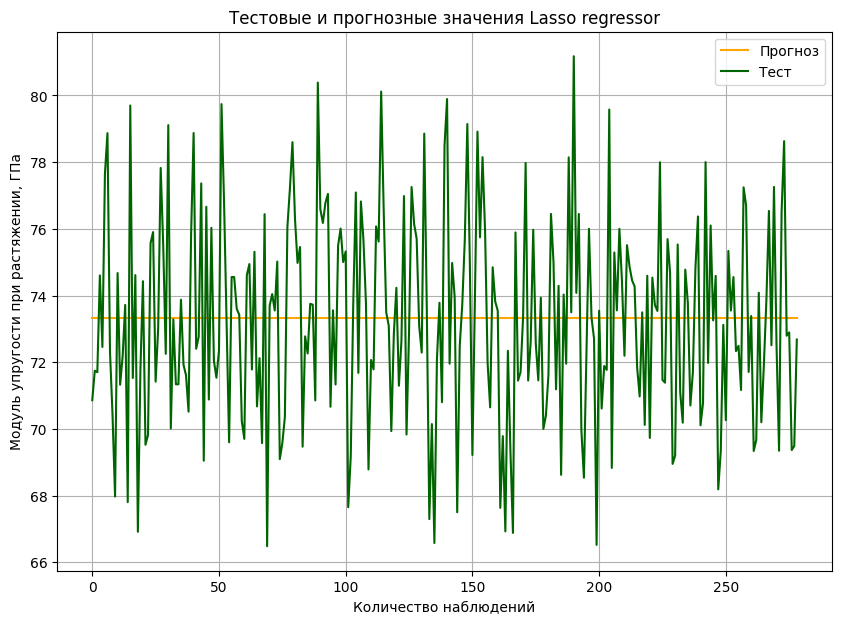

In [28]:
# Визуализация прогнозных и тестовых значений для модели Лассо
plt.figure(figsize=(10, 7))
plt.title("Тестовые и прогнозные значения Lasso regressor")
plt.plot(y_pred_clf2, label="Прогноз", color='orange')  # Прогнозные значения (оранжевый цвет)
plt.plot(y_test_2.values, label="Тест", color='darkgreen')  # Тестовые значения (темно-зеленый цвет)
plt.xlabel("Количество наблюдений")  # Подпись для оси X
plt.ylabel("Модуль упругости при растяжении, ГПа")  # Подпись для оси Y
plt.legend()  # Легенда для графика
plt.grid(True)  # Сетка на графике
plt.show()  # Отображаем график

In [29]:
# Сравниваем производительность различных регрессоров по метрике MAE (средняя абсолютная ошибка)
mae_df2 = {
    'Регрессор': [
        'Support Vector', 
        'Random Forest', 
        'Linear Regression', 
        'Gradient Boosting', 
        'K-Nearest Neighbors', 
        'Decision Tree', 
        'Stochastic Gradient Descent', 
        'Multi-layer Perceptron', 
        'Lasso'
    ], 
    'MAE': [
        mae_svr2, 
        mae_rfr2, 
        mae_lr2, 
        mae_gbr2, 
        mae_knn_model, 
        mae_dtr2, 
        mae_sdg2, 
        mae_mlp2, 
        mae_clf2
    ]
}

# Преобразуем в DataFrame для удобства анализа и визуализации
mae_df2 = pd.DataFrame(mae_df2)

In [30]:
# Определение сетки гиперпараметров для модели случайного леса
parametrs = { 
    'n_estimators': [200, 300],          # Количество деревьев в лесу
    'max_depth': [9, 15],                 # Максимальная глубина деревьев
    'max_features': ['sqrt'],             # Количество признаков для поиска на каждом шаге
    'criterion': ['squared_error']        # Критерий для оценки качества разбиения (заменили 'mse' на 'squared_error')
}

# Инициализация GridSearchCV для модели случайного леса
grid21 = GridSearchCV(estimator=rfr2, param_grid=parametrs, cv=10)

# Обучение модели с перекрестной проверкой
grid21.fit(x_train_2, y_train_2)

# Выводим наилучшие параметры после выполнения поиска
print("Best parameters found: ", grid21.best_params_)

Best parameters found:  {'criterion': 'squared_error', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 300}


In [31]:
# После успешного завершения обучения, вывести наилучшие параметры
print(grid21.best_params_)

{'criterion': 'squared_error', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 300}


In [32]:
# Выводим R2-score после округления
r2_score = grid21.best_estimator_.score(x_test_2, y_test_2)
print(f'R2-score для RandomForestRegressor: {round(r2_score, 3)}')

R2-score для RandomForestRegressor: -0.015


In [33]:
# Подставляем оптимальные гиперпараметры в модель случайного леса
rfr21_grid = RandomForestRegressor(n_estimators=200, criterion='squared_error', max_depth=15, max_features='sqrt')

# Обучаем модель
rfr21_grid.fit(x_train_2, y_train_2)

# Делаем прогноз на тестовых данных
predictions_rfr21_grid = rfr21_grid.predict(x_test_2)

# Оцениваем точность на тестовом наборе, вычисляем MAE
mae_rfr21_grid = mean_absolute_error(predictions_rfr21_grid, y_test_2)
print(f'MAE для модели с оптимальными гиперпараметрами: {mae_rfr21_grid}')

MAE для модели с оптимальными гиперпараметрами: 2.4738642870925793


In [34]:
# Добавляем новую строку в DataFrame
new_row_in_mae_df = {'Регрессор': 'RandomForest1_GridSearchCV', 'MAE': mae_rfr21_grid}

# Добавляем строку в DataFrame, используя pd.concat()
mae_df = pd.concat([mae_df2, pd.DataFrame([new_row_in_mae_df])], ignore_index=True)

# Печатаем обновленный DataFrame
mae_df

,Регрессор,MAE
0,Support Vector,3.252724
1,Random Forest,2.518220
2,Linear Regression,2.501728
3,Gradient Boosting,2.587578
4,K-Nearest Neighbors,2.646751
5,Decision Tree,3.532503
6,Stochastic Gradient Descent,2.472880
7,Multi-layer Perceptron,3.231697
8,Lasso,2.443231
9,RandomForest1_GridSearchCV,2.473864


In [35]:
# Определяем параметры поиска для K Neighbors Regressor
knn21 = KNeighborsRegressor()
knn21_params = {
    'n_neighbors' : range(1, 301, 2),  # проверяем n_neighbors с шагом 2
    'weights' : ['uniform', 'distance'],  # варианты весов
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']  # алгоритмы для нахождения соседей
}

# Запускаем GridSearchCV для поиска гиперпараметров с кросс-валидацией
gs21 = GridSearchCV(knn21, knn21_params, cv=10, verbose=1, n_jobs=-1, scoring='r2')
gs21.fit(x_train_2, y_train_2)

# Извлекаем и выводим лучшие параметры модели
knn_21 = gs21.best_estimator_
best_params = gs21.best_params_
print("Лучшие параметры для K Neighbors Regressor:", best_params)

Fitting 10 folds for each of 1200 candidates, totalling 12000 fits
Лучшие параметры для K Neighbors Regressor: {'algorithm': 'auto', 'n_neighbors': 267, 'weights': 'uniform'}


In [36]:
# Выводим гиперпараметры для оптимальной модели
print(gs21.best_estimator_)

# Применяем оптимальную модель для вычисления R^2
gs121 = gs21.best_estimator_

# Выводим R2-score для тестовой выборки, округленный до трех знаков
r2_score_knr = gs121.score(x_test_2, y_test_2)
print(f'R2-score KNR для модуля упругости при растяжении: {round(r2_score_knr, 3)}')

KNeighborsRegressor(n_neighbors=267)
R2-score KNR для модуля упругости при растяжении: -0.007


In [37]:
# Подставляем оптимальные гиперпараметры в модель K Neighbors Regressor
knn21_grid = KNeighborsRegressor(algorithm='brute', n_neighbors=7, weights='distance')

# Обучаем модель
knn21_grid.fit(x_train_2, y_train_2)

# Делаем предсказания на тестовой выборке
predictions_knn21_grid = knn21_grid.predict(x_test_2)

# Оцениваем модель по метрике MAE
mae_knn21_grid = mean_absolute_error(predictions_knn21_grid, y_test_2)

# Выводим MAE
print(f'MAE для модели KNN с оптимальными гиперпараметрами: {mae_knn21_grid}')

MAE для модели KNN с оптимальными гиперпараметрами: 2.585853383370045


In [38]:
# Создание новой строки с результатами
new_row_in_mae_df = {'Регрессор': 'KNeighbors1_GridSearchCV', 'MAE': mae_knn21_grid} 

# Добавление новой строки в DataFrame
mae_df = pd.concat([mae_df, pd.DataFrame([new_row_in_mae_df])], ignore_index=True)

# Выводим обновленный DataFrame
mae_df

,Регрессор,MAE
0,Support Vector,3.252724
1,Random Forest,2.518220
2,Linear Regression,2.501728
3,Gradient Boosting,2.587578
4,K-Nearest Neighbors,2.646751
5,Decision Tree,3.532503
6,Stochastic Gradient Descent,2.472880
7,Multi-layer Perceptron,3.231697
8,Lasso,2.443231
9,RandomForest1_GridSearchCV,2.473864


In [39]:
# Параметры для GridSearchCV
criterion21 = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter21 = ['best', 'random']
max_depth21 = [3, 5, 7, 9, 11]
min_samples_leaf21 = [100, 150, 200]
min_samples_split21 = [200, 250, 300]
max_features21 = ['auto', 'sqrt', 'log2']

param_grid21 = {
    'criterion': criterion21,
    'splitter': splitter21,
    'max_depth': max_depth21,
    'min_samples_split': min_samples_split21,
    'min_samples_leaf': min_samples_leaf21,
    'max_features': max_features21
}

# Инициализация модели DecisionTreeRegressor
dtr2 = DecisionTreeRegressor(random_state=42)

# Выполнение поиска по сетке с перекрестной проверкой
gs21 = GridSearchCV(dtr2, param_grid21, cv=10, verbose=1, n_jobs=-1, scoring='r2')
gs21.fit(x_train_2, y_train_2)

# Выводим лучшие гиперпараметры
print("Лучшие гиперпараметры:", gs21.best_params_)

Fitting 10 folds for each of 1080 candidates, totalling 10800 fits
Лучшие гиперпараметры: {'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 100, 'min_samples_split': 200, 'splitter': 'random'}


In [40]:
# Выводим гиперпараметры для оптимальной модели
print("Оптимальная модель:", gs21)

# Оценка точности модели на тестовом наборе данных
r2_score = gs21.score(x_test_2, y_test_2)

# Выводим R2-score с округлением до 3 знаков после запятой
print(f'R2-score DTR для модуля упругости при растяжении: {r2_score:.3f}')

Оптимальная модель: GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [3, 5, 7, 9, 11],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [100, 150, 200],
                         'min_samples_split': [200, 250, 300],
                         'splitter': ['best', 'random']},
             scoring='r2', verbose=1)
R2-score DTR для модуля упругости при растяжении: -0.009


In [42]:
# Инициализация модели деревьев решений с оптимальными гиперпараметрами, полученными с помощью GridSearchCV
dtr21_optimized = DecisionTreeRegressor(
    criterion='poisson', 
    max_depth=7, 
    max_features='sqrt', 
    min_samples_leaf=100, 
    min_samples_split=250
)

# Обучение модели на тренировочных данных
dtr21_optimized.fit(x_train_2, y_train_2)

# Прогнозирование на тестовом наборе данных
predictions_dtr21_optimized = dtr21_optimized.predict(x_test_2)

# Оценка точности модели с использованием метрики MAE (средняя абсолютная ошибка)
mae_dtr21_optimized = mean_absolute_error(predictions_dtr21_optimized, y_test_2)

# Вывод результата MAE
mae_dtr21_optimized

2.5054557668938924

In [43]:
# Создаем новую строку с результатами
new_row_in_mae_df = {'Регрессор': 'DecisionTree1_GridSearchCV', 'MAE': mae_dtr21_optimized}

# Добавляем строку в DataFrame с использованием pd.concat
mae_df = pd.concat([mae_df, pd.DataFrame([new_row_in_mae_df])], ignore_index=True)

# Выводим обновленный DataFrame
mae_df

,Регрессор,MAE
0,Support Vector,3.252724
1,Random Forest,2.518220
2,Linear Regression,2.501728
3,Gradient Boosting,2.587578
4,K-Nearest Neighbors,2.646751
5,Decision Tree,3.532503
6,Stochastic Gradient Descent,2.472880
7,Multi-layer Perceptron,3.231697
8,Lasso,2.443231
9,RandomForest1_GridSearchCV,2.473864


In [46]:
# Пайплайн для регрессора
pipe2 = Pipeline([
    ('preprocessing', StandardScaler()),  # Стандартизируем данные
    ('regressor', SVR())  # В данном случае используем SVR
])

# Сетка гиперпараметров для GridSearchCV
param_grid2 = [
    # SVR с различными параметрами
    {'regressor': [SVR()],
     'preprocessing': [StandardScaler(), MinMaxScaler(), None],
     'regressor__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    
    # RandomForest с различными параметрами
    {'regressor': [RandomForestRegressor(n_estimators=100)],
     'preprocessing': [StandardScaler(), MinMaxScaler(), None]},
    
    # Линейная регрессия
    {'regressor': [LinearRegression()],
     'preprocessing': [StandardScaler(), MinMaxScaler(), None]},
    
    # Градиентный бустинг
    {'regressor': [GradientBoostingRegressor()],
     'preprocessing': [StandardScaler(), MinMaxScaler(), None]},
    
    # Метод K ближайших соседей
    {'regressor': [KNeighborsRegressor()],
     'preprocessing': [StandardScaler(), MinMaxScaler(), None]},
    
    # Дерево решений
    {'regressor': [DecisionTreeRegressor()],
     'preprocessing': [StandardScaler(), MinMaxScaler(), None]},
    
    # Стохастический градиентный спуск
    {'regressor': [SGDRegressor()],
     'preprocessing': [StandardScaler(), MinMaxScaler(), None]},
    
    # Многослойный перцептрон
    {'regressor': [MLPRegressor(random_state=1, max_iter=500)],
     'preprocessing': [StandardScaler(), MinMaxScaler(), None]},
    
    # Лассо регрессия
    {'regressor': [Lasso(alpha=0.1)],
     'preprocessing': [StandardScaler(), MinMaxScaler(), None]}
]

# Создание GridSearchCV с кросс-валидацией
grid2 = GridSearchCV(pipe2, param_grid2, cv=10, n_jobs=-1, verbose=1)
grid2.fit(x_train_2, np.ravel(y_train_2))

# Вывод лучших параметров и результатов
print("Наилучшие параметры:\n{}".format(grid2.best_params_))
print("Наилучшее значение правильности перекрестной проверки: {:.2f}".format(grid2.best_score_))
print("Правильность на тестовом наборе: {:.2f}".format(grid2.score(x_test_2, y_test_2)))

Fitting 10 folds for each of 132 candidates, totalling 1320 fits
Наилучшие параметры:
{'preprocessing': StandardScaler(), 'regressor': SVR(), 'regressor__C': 1, 'regressor__gamma': 1}
Наилучшее значение правильности перекрестной проверки: -0.01
Правильность на тестовом наборе: 0.00


In [47]:
print("Наилучшая модель:\n{}".format(grid2.best_estimator_))

Наилучшая модель:
Pipeline(steps=[('preprocessing', StandardScaler()),
                ('regressor', SVR(C=1, gamma=1))])


После завершения процесса обучения моделей была проведена оценка их точности как на обучающей, так и на тестовой выборках. Для количественной оценки качества модели использовалась метрика средней абсолютной ошибки (MAE), которая позволяет измерить среднее отклонение предсказанных значений от истинных.

Однако, несмотря на попытки обучения, обе модели не смогли адекватно подстроиться под данные даже на этапе обучения. Это свидетельствует о том, что модель не смогла выявить значимые зависимости между признаками и целевой переменной, что, в свою очередь, привело к высокой ошибке на обучающей выборке. Поскольку модели не смогли эффективно обучиться на тренировочных данных, их производительность на тестовом наборе оказалась ещё хуже, что обусловлено неспособностью модели обобщать и делать точные предсказания для новых, ранее не встречавшихся данных.

Таким образом, ошибки на обеих выборках, обучающей и тестовой, остаются значительными, что указывает на возможные проблемы с качеством данных, моделью или её гиперпараметрами, требующими дополнительной настройки и оптимизации.

Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель.

In [63]:
# Определим зависимую и независимую переменные для задачи
target_variable = df['Соотношение матрица-наполнитель']
features = df.drop(columns=['Соотношение матрица-наполнитель'])

# Разделение исходных данных на обучающую и тестовую выборки
# Применим метод train_test_split для создания выборок
x_train, x_test, y_train, y_test = train_test_split(features, target_variable, test_size=0.3, random_state=14)


In [64]:
# Применим нормализацию к обучающим данным для стандартизации признаков
normalizer = tf.keras.layers.Normalization(axis=-1)

# Настроим нормализатор, используя обучающую выборку
normalizer.adapt(np.array(x_train))

In [65]:
def create_model(layers=[32], activation='softmax', optimizer='SGD', dropout_rate=0.1):
    # Устанавливаем фиксированное начальное состояние для воспроизводимости результатов
    seed_value = 7
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    # Создаём последовательную модель
    model = Sequential()

    # Добавляем первый скрытый слой с заданным числом нейронов
    model.add(Dense(layers[0], input_dim=x_train.shape[1], activation=activation))

    # Добавляем остальные скрытые слои
    for layer_size in layers[1:]:
        model.add(Dense(layer_size, activation=activation))

    # Добавляем слой Dropout для регуляризации
    model.add(Dropout(dropout_rate))

    # Выходной слой, количество нейронов = 3, активация tanh
    model.add(Dense(3, activation='tanh'))  # выходной слой

    # Компиляция модели с заданной функцией потерь и оптимизатором
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['mae', 'accuracy'])

    return model

In [66]:
# Создание модели с использованием функции build_fn
model = KerasClassifier(build_fn=create_model, verbose=0)

# Определение диапазонов гиперпараметров для поиска
batch_size_options = [4, 10, 20, 50, 100]
epoch_options = [10, 50, 100, 200, 300]

# Формирование сетки гиперпараметров
param_grid = dict(batch_size=batch_size_options, epochs=epoch_options)

# Инициализация поиска с перекрёстной проверкой (кросс-валидацией)
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=10,
                           verbose=1, 
                           n_jobs=-1)

# Запуск поиска оптимальных гиперпараметров
grid_result = grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [67]:
# Выводим результаты поиска оптимальных гиперпараметров
print("Лучший результат: %f с использованием параметров %s" % (grid_result.best_score_, grid_result.best_params_))

# Извлекаем статистику по результатам кросс-валидации
mean_scores = grid_result.cv_results_['mean_test_score']
std_devs = grid_result.cv_results_['std_test_score']
parameter_combinations = grid_result.cv_results_['params']

# Выводим среднее значение, стандартное отклонение и соответствующие параметры для каждой комбинации
for mean_score, std_dev, params in zip(mean_scores, std_devs, parameter_combinations):
    print("%f (%f) с параметрами: %r" % (mean_score, std_dev, params))

Лучший результат: 0.003077 с использованием параметров {'batch_size': 10, 'epochs': 200}
0.001538 (0.004615) с параметрами: {'batch_size': 4, 'epochs': 10}
0.001538 (0.004615) с параметрами: {'batch_size': 4, 'epochs': 50}
0.001538 (0.004615) с параметрами: {'batch_size': 4, 'epochs': 100}
0.001538 (0.004615) с параметрами: {'batch_size': 4, 'epochs': 200}
0.001538 (0.004615) с параметрами: {'batch_size': 4, 'epochs': 300}
0.000000 (0.000000) с параметрами: {'batch_size': 10, 'epochs': 10}
0.001538 (0.004615) с параметрами: {'batch_size': 10, 'epochs': 50}
0.001538 (0.004615) с параметрами: {'batch_size': 10, 'epochs': 100}
0.003077 (0.006154) с параметрами: {'batch_size': 10, 'epochs': 200}
0.000000 (0.000000) с параметрами: {'batch_size': 10, 'epochs': 300}
0.001538 (0.004615) с параметрами: {'batch_size': 20, 'epochs': 10}
0.001538 (0.004615) с параметрами: {'batch_size': 20, 'epochs': 50}
0.003077 (0.006154) с параметрами: {'batch_size': 20, 'epochs': 100}
0.001538 (0.004615) с пар

In [71]:
# Создание модели с фиксированными параметрами
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=4, verbose=0)

# Определение множества возможных оптимизаторов для поиска
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Nadam']

# Формирование сетки гиперпараметров для поиска
param_grid = dict(optimizer=optimizers)

# Инициализация поиска с кросс-валидацией
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=10, 
                           verbose=2)

# Запуск поиска лучших гиперпараметров
grid_result = grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ......................................optimizer=SGD; total time=   5.1s
[CV] END ......................................optimizer=SGD; total time=   4.9s
[CV] END ......................................optimizer=SGD; total time=   4.5s
[CV] END ......................................optimizer=SGD; total time=   4.9s
[CV] END ......................................optimizer=SGD; total time=   4.7s
[CV] END ......................................optimizer=SGD; total time=   4.7s
[CV] END ......................................optimizer=SGD; total time=   4.7s
[CV] END ......................................optimizer=SGD; total time=   4.6s
[CV] END ......................................optimizer=SGD; total time=   4.7s
[CV] END ......................................optimizer=SGD; total time=   4.6s
[CV] END ..................................optimizer=RMSprop; total time=   4.8s
[CV] END ..................................optim

In [72]:
# Результаты поиска лучших гиперпараметров
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Извлечение статистических данных из результатов кросс-валидации
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# Печать подробной информации о результатах
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.003077 using {'optimizer': 'Adagrad'}
0.001538 (0.004615) with: {'optimizer': 'SGD'}
0.001538 (0.004615) with: {'optimizer': 'RMSprop'}
0.003077 (0.006154) with: {'optimizer': 'Adagrad'}
0.001538 (0.004615) with: {'optimizer': 'Adadelta'}
0.001538 (0.004615) with: {'optimizer': 'Adam'}
0.001538 (0.004615) with: {'optimizer': 'Nadam'}


In [ ]:
# Функция для создания модели с динамическим количеством слоев
def create_model(lyrs):
    model = Sequential()
    for units in lyrs:
        model.add(Dense(units=units, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Например, для бинарной классификации
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Пример списка слоев для GridSearch
layers = [[8], [16, 4], [32, 8, 3], [12, 6, 3], [64, 64, 3], [128, 64, 16, 3]]

# Создаем KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=4, verbose=0)

# Параметры для GridSearch
param_grid = {'lyrs': layers}

# Выполняем GridSearch с кросс-валидацией
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=2)

# Обучаем модель
grid_result = grid.fit(x_train, y_train)


Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END ...........................................lyrs=[8]; total time=   4.6s
[CV] END ...........................................lyrs=[8]; total time=   4.8s
[CV] END ...........................................lyrs=[8]; total time=   4.5s
[CV] END ...........................................lyrs=[8]; total time=   4.6s
[CV] END ...........................................lyrs=[8]; total time=   4.9s
[CV] END ...........................................lyrs=[8]; total time=   4.7s
[CV] END ...........................................lyrs=[8]; total time=   4.5s
[CV] END ...........................................lyrs=[8]; total time=   4.3s
[CV] END ...........................................lyrs=[8]; total time=   4.3s
[CV] END ...........................................lyrs=[8]; total time=   4.3s
[CV] END .......................................lyrs=[16, 4]; total time=   4.5s
[CV] END .......................................

In [78]:
# Выводим лучшие результаты
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Печатаем результаты для всех комбинаций
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Best: 0.0015384615398943424 using {'lyrs': [8]}
0.0015384615398943424 (0.004615384619683027) with: {'lyrs': [8]}
0.0015384615398943424 (0.004615384619683027) with: {'lyrs': [16, 4]}
0.0015384615398943424 (0.004615384619683027) with: {'lyrs': [32, 8, 3]}
0.0015384615398943424 (0.004615384619683027) with: {'lyrs': [12, 6, 3]}
0.0015384615398943424 (0.004615384619683027) with: {'lyrs': [64, 64, 3]}
0.0015384615398943424 (0.004615384619683027) with: {'lyrs': [128, 64, 16, 3]}


In [79]:
# Функция для создания модели с параметром активации
def create_model(act='relu'):
    model = Sequential()
    model.add(Dense(units=8, input_dim=x_train.shape[1], activation=act))  # Первый слой с заданной активацией
    model.add(Dense(units=1, activation='sigmoid'))  # Выходной слой (для бинарной классификации)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Список активационных функций для GridSearch
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

# Создаем KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=4, verbose=0)

# Параметры для GridSearch (теперь передаем 'act')
param_grid = {'act': activation}

# Выполняем GridSearch с кросс-валидацией
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)

# Обучаем модель
grid_result = grid.fit(x_train, y_train)

# Выводим лучшие результаты
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Печатаем результаты для всех комбинаций
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Best: 0.0015384615398943424 using {'act': 'softmax'}
0.0015384615398943424 (0.004615384619683027) with: {'act': 'softmax'}
0.0015384615398943424 (0.004615384619683027) with: {'act': 'softplus'}
0.0015384615398943424 (0.004615384619683027) with: {'act': 'softsign'}
0.0015384615398943424 (0.004615384619683027) with: {'act': 'relu'}
0.0015384615398943424 (0.004615384619683027) with: {'act': 'tanh'}
0.0015384615398943424 (0.004615384619683027) with: {'act': 'sigmoid'}
0.0015384615398943424 (0.004615384619683027) with: {'act': 'hard_sigmoid'}
0.0015384615398943424 (0.004615384619683027) with: {'act': 'linear'}


In [80]:
# Функция для создания модели с параметром dropout
def create_model(dr=0.0):
    model = Sequential()
    model.add(Dense(units=8, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(dr))  # Добавление слоя Dropout с параметром dr
    model.add(Dense(units=1, activation='sigmoid'))  # Выходной слой (для бинарной классификации)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Список возможных значений для Dropout
drops = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

# Создаем KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=4, verbose=0)

# Параметры для GridSearch (передаем 'dr' как значение dropout)
param_grid = {'dr': drops}

# Выполняем GridSearch с кросс-валидацией
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10, verbose=2)

# Обучаем модель
grid_result = grid.fit(x_train, y_train)

# Выводим лучшие результаты
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Печатаем результаты для всех комбинаций
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best: 0.0015384615398943424 using {'dr': 0.0}
0.0015384615398943424 (0.004615384619683027) with: {'dr': 0.0}
0.0015384615398943424 (0.004615384619683027) with: {'dr': 0.01}
0.0015384615398943424 (0.004615384619683027) with: {'dr': 0.05}
0.0015384615398943424 (0.004615384619683027) with: {'dr': 0.1}
0.0015384615398943424 (0.004615384619683027) with: {'dr': 0.2}
0.0015384615398943424 (0.004615384619683027) with: {'dr': 0.3}
0.0015384615398943424 (0.004615384619683027) with: {'dr': 0.5}


In [82]:
# Функция для создания модели с параметрами для слоев и Dropout
def create_model(lyrs=[128, 64, 16, 3], dr=0.05):
    model = Sequential()
    
    # Входной слой
    model.add(Dense(units=lyrs[0], input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(dr))  # Добавление слоя Dropout
    
    # Добавляем скрытые слои
    for units in lyrs[1:]:
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(dr))  # Слой Dropout после каждого скрытого слоя
    
    # Выходной слой (предположим для бинарной классификации)
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Компиляция модели
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Создание модели с заданными параметрами
model = create_model(lyrs=[128, 64, 16, 3], dr=0.05)

# Выводим структуру модели
print(model.summary())

Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_360 (Dense)           (None, 128)               1920      
                                                                 
 dropout_64 (Dropout)        (None, 128)               0         
                                                                 
 dense_361 (Dense)           (None, 64)                8256      
                                                                 
 dropout_65 (Dropout)        (None, 64)                0         
                                                                 
 dense_362 (Dense)           (None, 16)                1040      
                                                                 
 dropout_66 (Dropout)        (None, 16)                0         
                                                                 
 dense_363 (Dense)           (None, 3)              

Epoch 1/100
17/17 [==============================] - 0s 9ms/step - loss: -2315.8594 - accuracy: 0.0000e+00 - val_loss: -5750.7275 - val_accuracy: 0.0000e+00
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: -11233.2490 - accuracy: 0.0000e+00 - val_loss: -20711.7344 - val_accuracy: 0.0000e+00
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: -35485.1055 - accuracy: 0.0000e+00 - val_loss: -61968.3516 - val_accuracy: 0.0000e+00
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: -101328.2422 - accuracy: 0.0000e+00 - val_loss: -164781.3750 - val_accuracy: 0.0000e+00
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: -252378.6094 - accuracy: 0.0000e+00 - val_loss: -399461.3750 - val_accuracy: 0.0000e+00
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: -585775.8125 - accuracy: 0.0000e+00 - val_loss: -880888.3750 - val_accuracy: 0.0000e+00
Epoch 7/100
17/17 [=======================

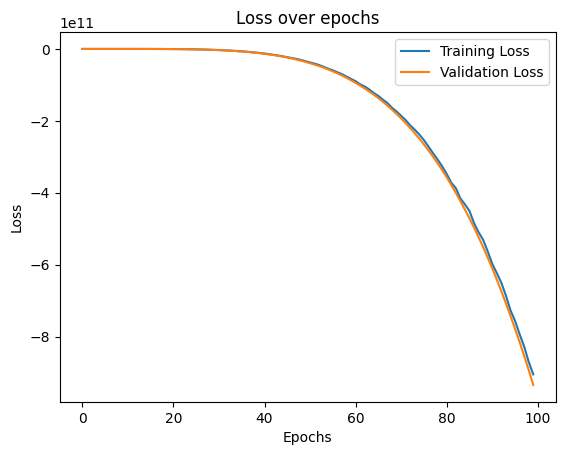

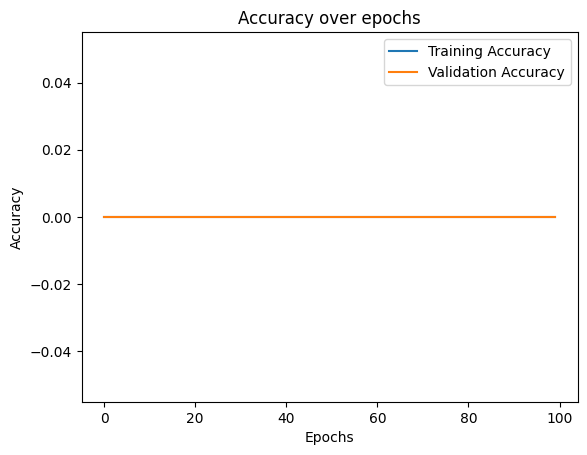

In [84]:

# Используем EarlyStopping для предотвращения переобучения
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Обучаем модель с 80/20 разделением данных
model_hist = model.fit(x_train, 
                       y_train, 
                       epochs=100, 
                       verbose=1, 
                       validation_split=0.2, 
                       callbacks=[early_stopping])  # Добавляем callback

# Просмотр результатов обучения
print("История обучения:")
print(model_hist.history)

# График потерь и точности
import matplotlib.pyplot as plt

# Потери
plt.plot(model_hist.history['loss'], label='Training Loss')
plt.plot(model_hist.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Точность
plt.plot(model_hist.history['accuracy'], label='Training Accuracy')
plt.plot(model_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [85]:
# Оценка модели на тестовых данных
scores = model.evaluate(x_test, y_test)

# Вывод всех метрик
for metric_name, score in zip(model.metrics_names, scores):
    print(f"{metric_name}: {score:.4f}")

# Вывод точности в процентах
print("\nAccuracy: %.2f%%" % (scores[1]*100))

9/9 [==============================] - 0s 875us/step - loss: -955772370944.0000 - accuracy: 0.0000e+00
loss: -955772370944.0000
accuracy: 0.0000

Accuracy: 0.00%


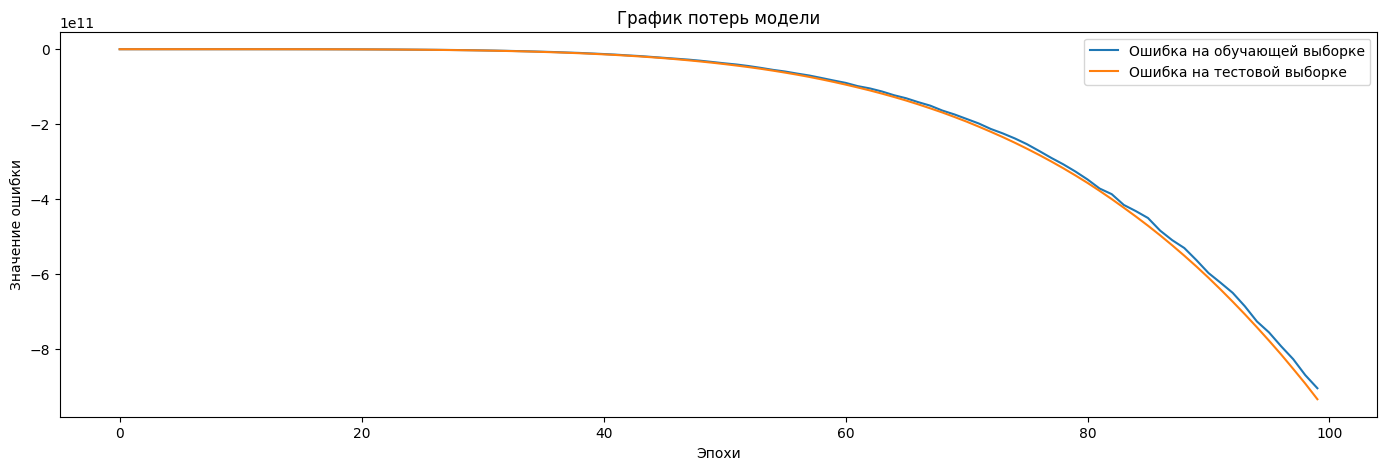

In [87]:
def model_loss_plot(model_hist):
    plt.figure(figsize=(17, 5))
    # Построение графика потерь для обучающей и тестовой выборок
    plt.plot(model_hist.history['loss'], label='ошибка на обучающей выборке')
    plt.plot(model_hist.history['val_loss'], label='ошибка на тестовой выборке')
    plt.title('График потерь модели')
    plt.ylabel('Значение ошибки')
    plt.xlabel('Эпохи')
    plt.legend(['Ошибка на обучающей выборке', 'Ошибка на тестовой выборке'], loc='best')
    plt.show()

# Вызов функции для отображения графика потерь
model_loss_plot(model_hist)

9/9 [==============================] - 0s 750us/step


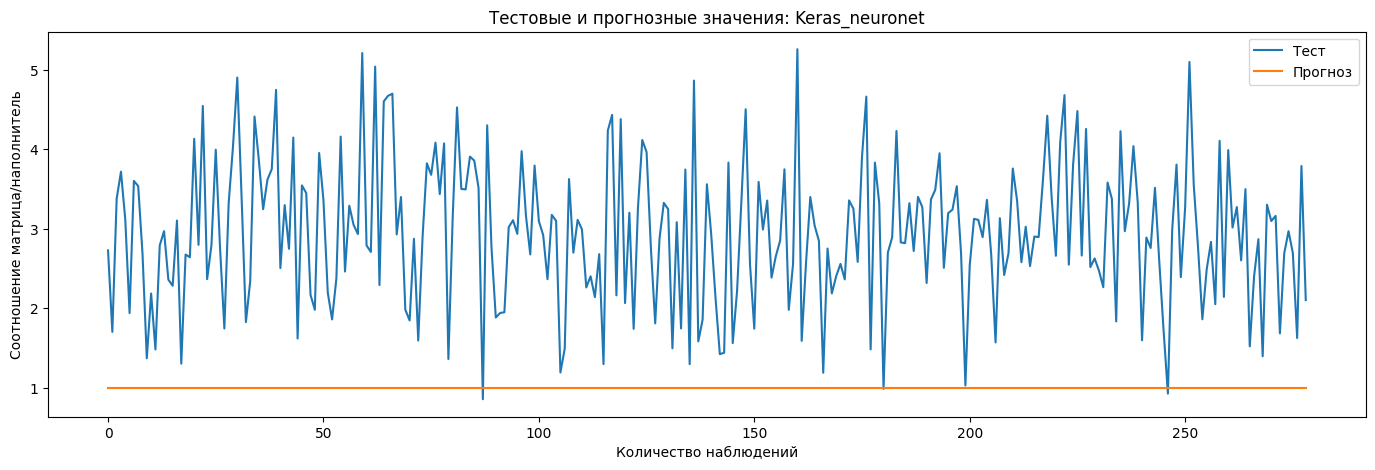

In [88]:
def actual_and_predicted_plot(orig, predict, var, model_name):    
    plt.figure(figsize=(17, 5))
    plt.title(f'Тестовые и прогнозные значения: {model_name}')
    plt.plot(orig, label='Тест')  # Истинные значения
    plt.plot(predict, label='Прогноз')  # Прогнозируемые значения
    plt.legend(loc='best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()

# Прогнозируем с помощью модели и выводим график
predict = model.predict(x_test.values).flatten()  # Преобразуем в одномерный массив, если нужно
actual_and_predicted_plot(y_test.values, predict, 'Cоотношение матрица/наполнитель', 'Keras_neuronet')

In [89]:
# Сконфигурируем модель
model1 = tf.keras.Sequential([
    Dense(128, activation='relu', input_shape=(x_train.shape[1],)),  # Убедитесь, что это входной слой
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Выходной слой
])

# Компиляция модели
model1.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
               loss='mean_squared_error', 
               metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Посмотрим на архитектуру модели
model1.summary()

Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_365 (Dense)           (None, 128)               1920      
                                                                 
 dense_366 (Dense)           (None, 128)               16512     
                                                                 
 dense_367 (Dense)           (None, 128)               16512     
                                                                 
 dense_368 (Dense)           (None, 64)                8256      
                                                                 
 dense_369 (Dense)           (None, 64)                4160      
                                                                 
 dense_370 (Dense)           (None, 32)                2080      
                                                                 
 dense_371 (Dense)           (None, 16)             

In [90]:
# Обучаем модель
model_hist1 = model1.fit(
    x_train,           # Тренировочные данные
    y_train,           # Целевая переменная
    epochs=100,        # Количество эпох
    verbose=1,         # Вывод процесса обучения
    validation_split=0.2  # Разделение 20% данных на валидационную выборку
)

Epoch 1/100
17/17 [==============================] - 1s 8ms/step - loss: 1860.7012 - root_mean_squared_error: 43.1358 - val_loss: 109.6748 - val_root_mean_squared_error: 10.4726
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 65.0455 - root_mean_squared_error: 8.0651 - val_loss: 44.4382 - val_root_mean_squared_error: 6.6662
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 18.5181 - root_mean_squared_error: 4.3033 - val_loss: 11.5324 - val_root_mean_squared_error: 3.3959
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 5.9160 - root_mean_squared_error: 2.4323 - val_loss: 3.6095 - val_root_mean_squared_error: 1.8999
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 4.2036 - root_mean_squared_error: 2.0503 - val_loss: 3.1708 - val_root_mean_squared_error: 1.7807
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 2.9697 - root_mean_squared_error: 1.7233 - val_loss: 3.4815 -

In [91]:
# Оценим модель на тестовых данных
scores = model1.evaluate(x_test, y_test)

# Выведем результаты
print(f'Потери (MSE): {scores[0]:.4f}')
print(f'RMSE: {scores[1]:.4f}')

9/9 [==============================] - 0s 876us/step - loss: 2.4040 - root_mean_squared_error: 1.5505
Потери (MSE): 2.4040
RMSE: 1.5505


In [92]:
# Предсказания модели
y_pred_model = model1.predict(x_test)

# Оценка модели
mae = mean_absolute_error(y_test, y_pred_model)
mape = mean_absolute_percentage_error(y_test, y_pred_model)
mse = mean_squared_error(y_test, y_pred_model)

# Вывод результатов
print('Model Results:')
print(f'Model MAE: {mae:.4f}')
print(f'Model MAPE: {mape*100:.2f}%')  # MAPE умножаем на 100 для процента
print(f'Model MSE: {mse:.4f}')

9/9 [==============================] - 0s 750us/step
Model Results:
Model MAE: 1.2458
Model MAPE: 40.22%
Model MSE: 2.4040


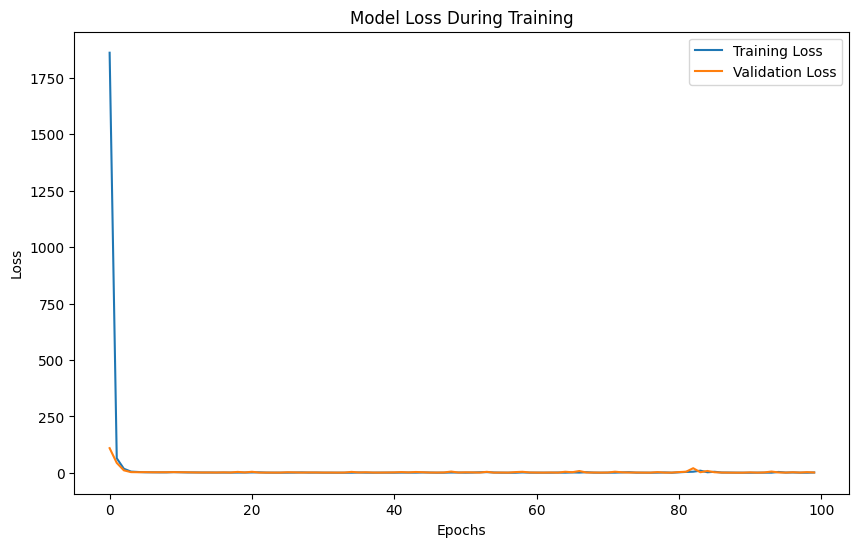

In [93]:
# Проверим историю обучения модели
model_hist1.history

# Если вы хотите построить график потерь, можно использовать следующий код:
import matplotlib.pyplot as plt

# График потерь на тренировочной и валидационной выборках
def plot_loss_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Визуализируем потери модели
plot_loss_history(model_hist1.history)

9/9 [==============================] - 0s 934us/step


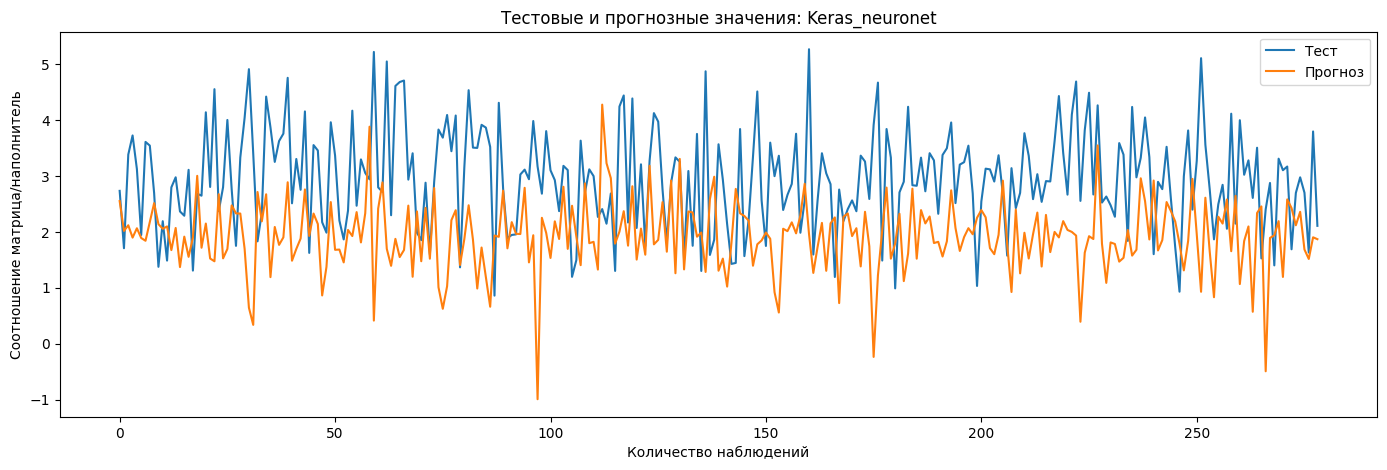

In [94]:
def actual_and_predicted_plot(orig, predict, var, model_name):
    """
    Функция для визуализации фактических и прогнозных значений.

    :param orig: Массив с фактическими значениями
    :param predict: Массив с прогнозными значениями
    :param var: Название переменной для отображения на графике
    :param model_name: Название модели для отображения на графике
    """
    # Преобразуем данные в одномерные массивы, если это необходимо
    orig = orig.flatten()
    predict = predict.flatten()

    # Построение графика
    plt.figure(figsize=(17, 5))
    plt.title(f'Тестовые и прогнозные значения: {model_name}')
    plt.plot(orig, label='Тест')
    plt.plot(predict, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()

# Прогнозируем значения и визуализируем результат
y_pred_model1 = model1.predict(x_test.values)  # Получаем прогнозные значения
actual_and_predicted_plot(y_test.values, y_pred_model1, 'Cоотношение матрица/наполнитель', 'Keras_neuronet')

In [95]:
# Оценка модели на тестовых данных
scores = model1.evaluate(x_test, y_test, verbose=1)

# Вывод результатов
print(f'MSE: {scores[0]:.4f}')
print(f'RMSE: {scores[1]:.4f}')

9/9 [==============================] - 0s 1ms/step - loss: 2.4040 - root_mean_squared_error: 1.5505
MSE: 2.4040
RMSE: 1.5505


9/9 [==============================] - 0s 875us/step


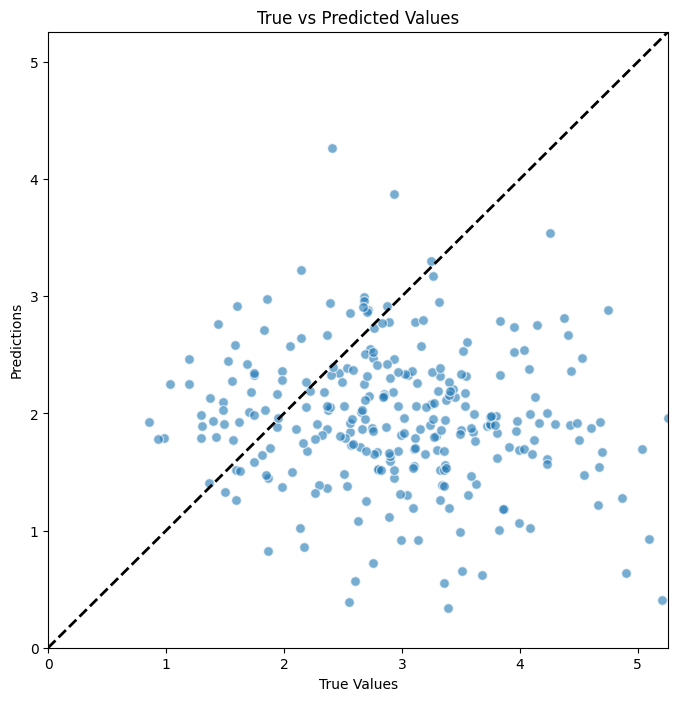

In [96]:
# Получение предсказаний модели
test_predictions = model1.predict(x_test).flatten()

# Создаем график
plt.figure(figsize=(8, 8))
a = plt.gca()
plt.scatter(y_test, test_predictions, alpha=0.6, edgecolors='w', s=50)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Устанавливаем пределы графика
lims = [0, max(y_test.max(), test_predictions.max())]  # Установим лимиты по максимуму из y_test и предсказаний
plt.xlim(lims)
plt.ylim(lims)

# Добавим диагональную линию (идеальная линия, где предсказания = истинные значения)
_ = plt.plot(lims, lims, 'k--', lw=2)  # Черная пунктирная линия

# Добавим заголовок
plt.title('True vs Predicted Values')

# Показать график
plt.show()